<h1> Statistical Machine Translation </h1>

In [3]:
!pip install pipreqs

You should consider upgrading via the 'g:\data science projects\msc final sem project\my_venv\scripts\python.exe -m pip install --upgrade pip' command.



  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Using cached idna-3.2-py3-none-any.whl (59 kB)
  Using cached urllib3-1.26.6-py2.py3-none-any.whl (138 kB)
  Using cached charset_normalizer-2.0.3-py3-none-any.whl (35 kB)
  Using cached certifi-2021.5.30-py2.py3-none-any.whl (145 kB)
Using legacy 'setup.py install' for docopt, since package 'wheel' is not installed.
    Running setup.py install for docopt: started
    Running setup.py install for docopt: finished with status 'done'


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd                  # data handling
import numpy as np
from tqdm import tqdm                # show progess bar
import time                          # to time the preocess
import matplotlib.pyplot as plt      # plotting graphs
import re                            # regular expression
from collections import OrderedDict  # used to convert dict to dataframe
import joblib
from math import log2, log
from decimal import Decimal
from tqdm import tqdm_notebook

## Data Preprocessing 

### Load the data

The original data parallel_corpus_french_english can be downloaded from [Europarl Parallel Corpus](https://www.statmt.org/europarl/) or [Click here](https://www.statmt.org/europarl/v7/fr-en.tgz) to download the zip file of 194MB.  

In [3]:
# Path of data
path_en ="/content/drive/MyDrive/Colab_Notebooks/DATA/europarl_fr-en/europarl-v7.fr-en.en"
path_fr ="/content/drive/MyDrive/Colab_Notebooks/DATA/europarl_fr-en/europarl-v7.fr-en.fr"

In [4]:
with open(path_fr,'r') as fr:
  fr = fr.read()
  
with open(path_en,'r') as en:
  en = en.read()

### Data Cleaning

In [5]:
# Cleaning of corpus 
def preprocessing(corpus):
  corpus = re.sub(r'[,?.{}()\";!@%$#]','', corpus)                  # Remove ,?.{}()\";!@%$# these symbols
  corpus = corpus.replace('[','').replace(']','')                   # Remove [] brackets
  corpus = corpus.lower().strip().split("\n")                       # Split into sentences
  return corpus

In [6]:
fr = preprocessing(fr)
en = preprocessing(en)

In [7]:
# Number of Sentences
print(len(fr),len(en))

2007723 2007723


In [8]:
# Class of data
print(type(fr),type(en))

<class 'list'> <class 'list'>


In [9]:
# Concatinate
df_list = list(zip(fr,en))

In [10]:
# Convert to Dataframe
fr_en = pd.DataFrame(df_list,columns=['French','English'])

In [11]:
list(fr_en.columns.values)

['French', 'English']

In [12]:
# View Dataframe
fr_en.head()

,French,English
0,reprise de la session,resumption of the session
1,je déclare reprise la session du parlement eur...,i declare resumed the session of the european ...
2,comme vous avez pu le constater le grand bogue...,although as you will have seen the dreaded 'mi...
3,vous avez souhaité un débat à ce sujet dans le...,you have requested a debate on this subject in...
4,en attendant je souhaiterais comme un certain ...,in the meantime i should like to observe a min...


### Analysis of French & English sentences

In [13]:
fr_en["French_count"] = fr_en["French"].str.split().str.len()

In [14]:
fr_en["English_count"] = fr_en["English"].str.split().str.len()

In [15]:
fr_en.head()

,French,English,French_count,English_count
0,reprise de la session,resumption of the session,4,4
1,je déclare reprise la session du parlement eur...,i declare resumed the session of the european ...,33,38
2,comme vous avez pu le constater le grand bogue...,although as you will have seen the dreaded 'mi...,37,31
3,vous avez souhaité un débat à ce sujet dans le...,you have requested a debate on this subject in...,19,19
4,en attendant je souhaiterais comme un certain ...,in the meantime i should like to observe a min...,38,40


In [16]:
# Summary of word counts
round(fr_en.describe())

,French_count,English_count
count,2007723.0,2007723.0
mean,26.0,25.0
std,16.0,15.0
min,0.0,0.0
25%,15.0,14.0
50%,23.0,22.0
75%,34.0,33.0
max,693.0,668.0


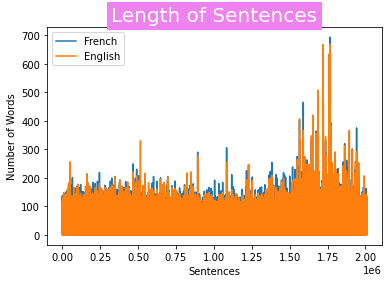

In [17]:
fr = fr_en["French_count"]
en = fr_en["English_count"]

plt.plot(fr)
plt.plot(en)
plt.legend(labels=("French","English"))
plt.xlabel("Sentences")
plt.ylabel("Number of Words")
plt.title("Length of Sentences",fontsize = 20, fontweight = 5, color= 'white',backgroundcolor='violet')
plt.show()

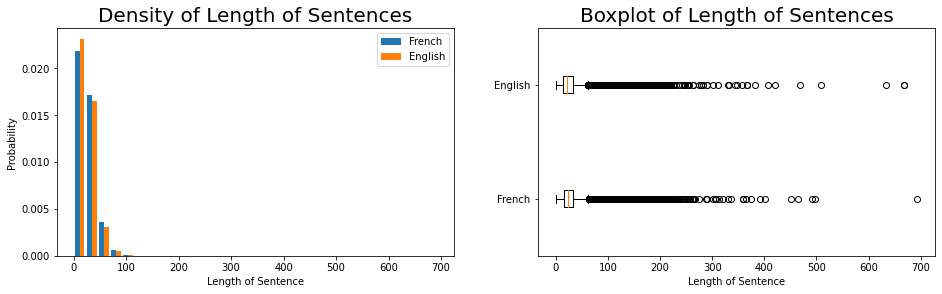

In [18]:
plt.subplots(figsize=(14,5))

plt.subplot(1,2,1)   # Postion of 1st plot (row,column,index)
plt.hist([fr,en],bins=30,density=True)
plt.legend(labels=("French","English"))
plt.xlabel("Length of Sentence")
plt.ylabel("Probability")
plt.title("Density of Length of Sentences",fontsize = 20, fontweight = 5)

plt.subplot(1,2,2)
plt.boxplot([fr,en],vert=False,labels=("French","English"))
plt.title("Boxplot of Length of Sentences",fontsize = 20, fontweight = 5)
plt.xlabel("Length of Sentence")
plt.tight_layout(4)
plt.show()

Graph shows that there are words with length zero. We will now have a look at them and analyze further.

### Analyzing partially missing sentences

#### Delete blank rows

In [19]:
# Sentences with 0 words
print('French Sentences with "0" words :',sum(fr_en['French_count']==0))
print('English Sentences with "0" words :',sum(fr_en['English_count']==0))

French Sentences with "0" words : 4060
English Sentences with "0" words : 3507


In [20]:
# Sentences with 0 French & English words 
zeros_b = fr_en[(fr_en['French_count']==0) & (fr_en['English_count']==0)]
print("Both French & English Sententences with '0' words :",len(zeros_b))

Both French & English Sententences with '0' words : 1520


In [21]:
zeros_fr = fr_en[fr_en['French_count']==0]
zeros_en = fr_en[fr_en['English_count']==0]

print(len(zeros_fr),len(zeros_en))

4060 3507


In [22]:
zeros_fr.head()

,French,English,French_count,English_count
549,,the third objective is urban and rural develop...,0,16
1487,,however this one would undoubtedly be one of t...,0,16
1815,,,0,0
1846,,,0,0
1852,,,0,0


#### At 549 - English sent is part of next row

In [23]:
fr_en['French'].iloc[548]              # Correct

"en ce qui me concerne - compte tenu de l' idée que je me fais de la construction européenne et de la politique de développement régional en particulier - c' est une situation que je n' accepte pas et j' ai bien l' intention autant que je le pourrai avec votre appui de mettre l' ensemble des crédits dont j' ai la responsabilité au service de cette meilleure cohésion sociale humaine territoriale notamment pour qu' il n' y ait pas ce que j' ai appelé devant vous un jour une europe à deux vitesses une europe des beaux quartiers et une europe des banlieues pauvres"

In [24]:
fr_en['English'].iloc[548]             # Correct

'as far as i am concerned - taking into account my own concept of the construction of europe and regional development policy in particular - this is a situation which i find unacceptable and i have every intention as far as possible with your support of dedicating all the appropriations for which i am responsible to this improved social human and territorial cohesion particularly in order to prevent what i once called in this house a two-speed europe a europe of wealthy districts but at the same time a europe of impoverished areas'

In [25]:
fr_en['French'].iloc[549]

''

In [26]:
fr_en['English'].iloc[549]      # translation below at french 550

'the third objective is urban and rural development within the scope of a balanced territorial policy'

In [27]:
fr_en['French'].iloc[550]

"le troisième objectif est celui du développement urbain et rural dans le cadre d' une politique territoriale équilibrée"

In [28]:
fr_en['English'].iloc[550]               # at french 551

'in fact the guidelines take two horizontal principles into account the first is rural development and let me say mrs schroedter that i am including in rural development the matter of sustainable transport an issue i have been involved in personally for a long time'

In [29]:
fr_en['French'].iloc[551]

"par ailleurs les orientations prennent en considération deux principes horizontaux : le développement rural et madame le rapporteur j' inclus bien dans le développement rural la question des transports durables à laquelle je suis personnellement attaché depuis assez longtemps - notamment me souvenant du moment où j' étais dans mon pays ministre de l' environnement - et le deuxième principe est celui de l' égalité des chances en particulier entre les femmes et les hommes ainsi que la stratégie européenne pour l' emploi et le cadre de l' union économique et monétaire"

In [30]:
fr_en['English'].iloc[551]                # at french 551

'i particularly remember the time when i was minister for the environment in my own country the second principle is that of equal opportunities particularly for men and women as well as the european strategy for employment and the context of economic and monetary union'

#### At 2006081 - English sent is part of previous row

In [31]:
fr_en['French'].iloc[2006080]

"le conflit largement entretenu de ces dernières semaines entre le parlement et le conseil ne doit pas nous faire oublier quelques questions essentielles : quant à l' aide octroyée à la province du kosovo on peut s' étonner que celle-ci ne soit pas conditionnée par le retour définitif à la paix ce qui n' est hélas pas le cas ainsi que le rappelle un récent rapport de l' osce  quant aux sommes allouées les membres de la commission des budgets ont assisté au fil des commissions à un véritable marchandage les institutions jonglant avec les millions d' euros sans que personne n' ait réellement pris la peine d' évaluer les besoins de la région chacun s' accordant à dire que le kosovo ne pouvait actuellement absorber de telles sommes équivalentes à la moitié de son pnb"

In [32]:
fr_en['English'].iloc[2006080]

'the conflict has been extensively discussed in recent weeks by parliament and the council but there are certain essential aspects which we must not forget with regard to the aid granted to kosovo it is surprising that this is not conditional on the definitive restoration of peace which has unfortunately not yet been achieved as indicated by a recent osce report'

In [33]:
fr_en['French'].iloc[2006081]

''

In [34]:
fr_en['English'].iloc[2006081]                 # This is part of 2006080

'as for the sums allocated the members of the committee on budgets have participated through the committees in some real bargaining'

In [35]:
fr_en['French'].iloc[2006082]

''

In [36]:
fr_en['English'].iloc[2006082]                  # This is part of 2006080

"the institutions have juggled with millions of euros without anyone really taking the trouble to assess the region' s needs yet everyone agrees that kosovo could not actually absorb such sums which are equivalent to half its gnp"

In [37]:
fr_en['French'].iloc[2006083]                   # Correct

"à ce titre on doit déplorer le manque de rigueur du commissaire chargé du budget qui interrogé par la commission des budgets s' est révélé incapable de donner une estimation chiffrée des montants nécessaires en euros mais uniquement en dollars"

In [38]:
fr_en['English'].iloc[2006083]                 # Correct

'in this respect we must deplore the lack of rigour shown by the commissioner responsible for the budget when questioned by the committee on budgets he was incapable of estimating the amounts needed in euros and could only give these in dollars'

In [39]:
df = fr_en.copy()

In [40]:
def delete_zeros(df):
  
  fr_idx = df[df['French_count']==0].index.to_list()
  
  en_idx = df[df['English_count']==0].index.to_list()

  fr_del = []
  for id in fr_idx:                
    fr_del.extend([id-1,id,id+1])

  for id in en_idx:                
    fr_del.extend([id-1,id,id+1])

  id_del = list(set(fr_del))

  return id_del

In [41]:
# Collect indices of rows to be deleted.
delete_rows = delete_zeros(df)
print(len(delete_rows),type(delete_rows))

15705 <class 'list'>


In [42]:
# Delete rows with given row indices.
df.drop(index=delete_rows,inplace=True)

### Delete Duplicate rows

In [43]:
print("Number of duplicate rows :",sum(df.duplicated()))

Number of duplicate rows : 39712


In [44]:
# Observe duplicate rows
duplicate = df[df.duplicated()]

In [45]:
duplicate['French'][:20]

13      madame la présidente c'est une motion de procé...
294                                     le débat est clos
295                  le vote aura lieu demain à 12 heures
586                                     le débat est clos
749                                     le débat est clos
750                       le vote aura lieu demain à midi
1450                 le vote aura lieu demain à 12 heures
1714                 le vote aura lieu demain à 12 heures
1735                    le parlement adopte la résolution
1737                    le parlement adopte la résolution
1739                    le parlement adopte la résolution
1741                    le parlement adopte la résolution
1743                    le parlement adopte la résolution
2050                             ce n' est plus tolérable
2053                             ce n' est plus tolérable
2390                                    le débat est clos
2785                               elle doit être visible
2825          

In [46]:
duplicate['English'][:20]

13                    madam president on a point of order
294                                  the debate is closed
295            the vote will take place tomorrow at 12 pm
586                                  the debate is closed
749                                  the debate is closed
750            the vote will take place tomorrow at 12 pm
1450           the vote will take place tomorrow at 12 pm
1714           the vote will take place tomorrow at 12 pm
1735                    parliament adopted the resolution
1737                    parliament adopted the resolution
1739                    parliament adopted the resolution
1741                    parliament adopted the resolution
1743                    parliament adopted the resolution
2050                          this is no longer tolerable
2053                          this is no longer tolerable
2390                                 the debate is closed
2785                                   it must be visible
2825          

In [47]:
# Delete duplicated rows by keeping only the first occurence
df.drop_duplicates(inplace=True,keep='first')

### Delete sentences with words more than 80

In [48]:
print("Sentences with 200 or more words :",sum(df['French_count']>=200))

Sentences with 200 or more words : 79


In [49]:
# Sentences with 100 or more words
print('French Sentences with 100 or more words :',sum(df['French_count']>=100))
print('English Sentences with 100 or more words :',sum(df['English_count']>=100))

French Sentences with 100 or more words : 4050
English Sentences with 100 or more words : 3010


In [50]:
# Sentences with 75 or more words
print('French Sentences with 80 or more words :',sum(df['French_count']>=80))
print('English Sentences with 80 or more words :',sum(df['English_count']>=80))

French Sentences with 80 or more words : 15414
English Sentences with 80 or more words : 11840


In [51]:
# Delete sentences with words more than 100 
df = df[df['French_count']<80]

### Check our cleaned corpora & take sample of 1000 sentences.

In [52]:
print("Number of Sentences in cleaned corpus :",len(df))

Number of Sentences in cleaned corpus : 1936892


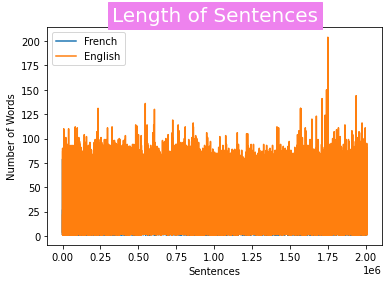

In [53]:
fr = df["French_count"]
en = df["English_count"]

plt.plot(fr)
plt.plot(en)
plt.legend(labels=("French","English"))
plt.xlabel("Sentences")
plt.ylabel("Number of Words")
plt.title("Length of Sentences",fontsize = 20, fontweight = 5, color= 'white',backgroundcolor='violet')
plt.show()

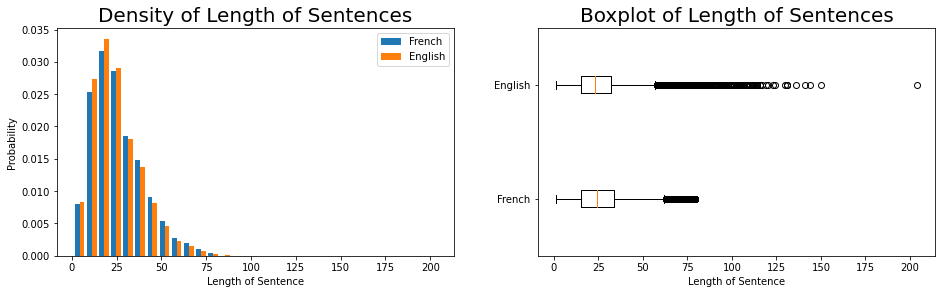

In [54]:
plt.subplots(figsize=(14,5))

plt.subplot(1,2,1)   # Postion of 1st plot (row,column,index)
plt.hist([fr,en],bins=30,density=True)
plt.legend(labels=("French","English"))
plt.xlabel("Length of Sentence")
plt.ylabel("Probability")
plt.title("Density of Length of Sentences",fontsize = 20, fontweight = 5)

plt.subplot(1,2,2)
plt.boxplot([fr,en],vert=False,labels=("French","English"))
plt.title("Boxplot of Length of Sentences",fontsize = 20, fontweight = 5)
plt.xlabel("Length of Sentence")
plt.tight_layout(4)
plt.show()

In [ ]:
# head = "French\tEnglish\tFrench_count\tEnglish_count"
# pd.save_csv('europarl_fr_en_txt.txt', df.values, fmt='%d', delimiter="\t", header= head)

In [ ]:
# Save cleaned fr_en 
#filename = 'cleaned_fr_en.joblib'
#joblib.dump(df, filename)

In [ ]:
# Load the clean data 'clean_fr_en.joblib' from disk
#filename = 'cleaned_fr_en.joblib'
#data = joblib.load(filename)

In [55]:
df

,French,English,French_count,English_count
0,reprise de la session,resumption of the session,4,4
1,je déclare reprise la session du parlement eur...,i declare resumed the session of the european ...,33,38
2,comme vous avez pu le constater le grand bogue...,although as you will have seen the dreaded 'mi...,37,31
3,vous avez souhaité un débat à ce sujet dans le...,you have requested a debate on this subject in...,19,19
4,en attendant je souhaiterais comme un certain ...,in the meantime i should like to observe a min...,38,40
...,...,...,...,...
2007715,je donne la parole à m manders pour une motion...,mr manders has the floor for a procedural motion,12,9
2007716,monsieur le président je voudrais profiter de ...,mr president i would like to take this opportu...,26,24
2007717,mesdames et messieurs les députés avant votre ...,ladies and gentlemen before you leave me alone...,57,64
2007718,je me permettrai même bien qu'ils soient absen...,i would also like although they are absent to ...,15,15


In [56]:
# Save cleaned data as csv file
df.to_csv('europarl_en_fr_cleaned.csv',sep=",")

In [57]:
len(df)

1936892

In [58]:
# Create a subset of dataset - sample of 50000
fr_en_50000 = df.sample(50000, replace=False, random_state=20)

In [59]:
len(fr_en_50000)

50000

In [60]:
# Save sample of cleaned data for training
fr_en_50000.to_csv('fr_en_50000.csv',sep=",")

## **Word Based Model**

### Import Cleaned Sample Data

In [61]:
# Import cleaned dataset sample
path = '/content/drive/MyDrive/Colab_Notebooks/DATA/fr_en_50000.csv'
fr_en_50000 = pd.read_csv(path, sep=",")

In [62]:
data = fr_en_50000.sample(frac=0.02,random_state=275221)
list(data.columns.values)

['Unnamed: 0', 'French', 'English', 'French_count', 'English_count']

In [63]:
# Remove first column -> 'Unnamed: 0'
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [64]:
data.head()

,French,English,French_count,English_count
4557,il aurait peut-être pu complimenter m solana q...,perhaps you could convey a compliment to mr so...,23,26
45334,pourquoi l'europe était-elle divisée,why was europe divided,4,4
44116,les réserves s'appliquent également au pouvoir...,reservations also apply to the discretionary p...,31,34
27564,une telle politique de restriction sera nature...,however this more restrictive policy is natura...,20,17
11588,ils peuvent continuer avec leur argent même s'...,they can continue with their money although th...,15,15


### Train-Test Split

In [65]:
# Split data into training and testing
train_data = data.sample(frac=0.8, random_state=1424)
test_data = data.drop(train_data.index)
print("Size of Training Data :", len(train_data))
print("Size of Testing Data :", len(test_data))

Size of Training Data : 800
Size of Testing Data : 200


In [66]:
def prob_e_f(f_s,e_s,t,eps=1):
  """
  ARGUMENTS: 
    f_s = list of tokens for french sentence
    e_s = list of tokens for english sentence
    t = dictionary of alignments

  OUTPUT : 
    returns p(e|f) - translation probability 
  """

  l_f = len(f_s)
  l_e = len(e_s)

  prod = 1    # This is for the iterative product of summations of t(e|f) 
              # (i.e. product_j[sum_i(t(e_j|f_i))] )
  for e in e_s:
    sum = 0
    for f in f_s:
      sum += t[(e,f)]
    prod = sum*prod   

  p_e_f = prod * eps / pow(l_f,l_e)
  return p_e_f

In [67]:
def dict_to_dataframe(dictionary_obj):
  """
  ARGUMENTS: A dictionary object
  OUTPUT: dataframe
  """

  eng = list(OrderedDict.fromkeys([k[0] for k in dictionary_obj.keys()]))
  fr = list(OrderedDict.fromkeys([k[1] for k in dictionary_obj.keys()]))
  val = np.reshape(np.array([v for v in dictionary_obj.values()]),(len(eng),-1))
  df = pd.DataFrame(val, index=eng, columns=fr)
  return df

In [68]:
# Creating English and French Vocabularies of Unique Words

foreign_words = []
english_words = []

for index, row in train_data.iterrows():
  for f in row.French.lower().strip().split():
    foreign_words.append(f)
    
  for e in row.English.lower().strip().split():
    english_words.append(e)

In [69]:
foreign_words = sorted(list(set(foreign_words)))
print('Foreign Vocabulary size :', len(foreign_words))
print('Foreign Vocabulary 10 words :', foreign_words[1000:1010])

Foreign Vocabulary size : 4773
Foreign Vocabulary 10 words : ['crée', 'créent', 'créer', 'créera', 'créé', 'csc', 'cuba', 'culpabilité', 'cultivables', 'culture']


In [70]:
english_words = sorted(list(set(english_words)))
print('English Vocabulary size :', len(english_words))
print('English Vocabulary 10 words :', english_words[1000:1010])

English Vocabulary size : 3842
English Vocabulary 10 words : ['demonstrated', 'demonstrates', 'denmark', 'denominator', 'department', 'departure', 'dependence', 'dependent', 'depends', 'deposits']


In [71]:
# Initialize t, total, count

t = {}

for f in foreign_words:
  for e in english_words:
    t[(e,f)] = 1/len(foreign_words)

In [72]:
# Initial translation probabilities
t_dataframe = dict_to_dataframe(t)
print(t_dataframe.shape)
t_dataframe.iloc[1230:1240,2780:2788]

(3842, 4773)


,messieurs,mesure,mesures,met,mettant,mettent,mettra,mettre
english,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021
enjoy,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021
enlargement,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021
enormous,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021
enough,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021
enshrined,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021
ensure,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021
ensured,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021
ensuring,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021
entailed,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021


### IBM model1 training.

In [73]:
def IBModel1(corpus, t, foreign_vocab = foreign_words, english_vocab = english_words, epochs = 10):
  perp_all = []

  for i in tqdm_notebook(range(epochs), total = epochs, unit = 'epoch'):

    # Initialize
    total = {}
    count = {}

    for f in foreign_vocab:
      total[f] = 0.0
      for e in english_vocab:
        count[(e,f)] = 0.0  

    perp = 0
    # Loop over all rows
    for index, row in corpus.iterrows():
      f_s = row.French.lower().strip().split()
      e_s = row.English.lower().strip().split()

      prob_ef = prob_e_f(f_s,e_s,t)
      d = Decimal(prob_ef)         # This probability is very small
      try:
        pp = -1.0*log2(d)                       # so converted to decimal to ease in finding log 
      except:
        pp = 799.99625657
              
      perp += pp
      
      # Compute normalization
      s_total = {} 
      for e in e_s:
        s_total[e] = 0.0                        # s-total(e) = 0
        for f in f_s:
          s_total[e] = s_total[e] + t[(e,f)]                # s-total(e) += t(e|f)
        
      # Collect counts
      for e in e_s:
        for f in f_s:
          count[(e,f)] = count[(e,f)] + t[(e,f)]/s_total[e]       # count(e|f) += t(e|f)/s-total(e)
          total[f] = total[f] + t[(e,f)]/s_total[e]           # total(f) += t(e|f)/s-total(e)

          t[(e,f)] = count[(e,f)]/total[f]      # t(e|f) = count(e|f)/total(f)

    perp_all.append(perp)

  return t, perp_all

In [74]:
# Check epochs before uncommenting - training for longer epochs would give much better results.
t , perplexity = IBModel1(train_data,t=t,epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


### A look at the translation probabilities for most common english-french words pair.

In [75]:
# 20 Most common words taken from - https://1000mostcommonwords.com/1000-most-common-french-words/ 
most_common_fr = 'comme je son que il était pour sur sont avec ils être à un avoir ce par chaud mot mais'
most_common_en = 'as i his that he was for on are with they be at one have this by hot word but'

tok_fr = most_common_fr.split()
tok_en = most_common_en.split()

print("20 Most common English words : \n",tok_en)
print("20 Most common French words : \n",tok_fr)

20 Most common English words : 
 ['as', 'i', 'his', 'that', 'he', 'was', 'for', 'on', 'are', 'with', 'they', 'be', 'at', 'one', 'have', 'this', 'by', 'hot', 'word', 'but']
20 Most common French words : 
 ['comme', 'je', 'son', 'que', 'il', 'était', 'pour', 'sur', 'sont', 'avec', 'ils', 'être', 'à', 'un', 'avoir', 'ce', 'par', 'chaud', 'mot', 'mais']


In [76]:
most_common = {}
for f in tok_fr:
  for e in tok_en:    
    try:
      most_common[(e,f)] = round(t[(e,f)],5)
    except:
      pass  

frequent_words = dict_to_dataframe(most_common)

In [77]:
# Alignment probability for 1-10  most common French-English words :
first_10 = frequent_words.iloc[:10,:10]
first_10

,comme,je,son,que,il,était,pour,sur,sont,avec
as,0.80348,0.01602,0.00001,0.00006,0.00021,0.00000,0.00000,0.00000,0.00417,0.00002
i,0.00000,0.00000,0.57519,0.00000,0.00005,0.00000,0.00000,0.00000,0.08032,0.00000
his,0.00000,0.00000,0.00000,0.00003,0.51345,0.00000,0.00000,0.00000,0.00818,0.00156
that,0.00021,0.00021,0.01250,0.00000,0.00000,0.00000,0.55287,0.00000,0.00000,0.00000
he,0.00000,0.00021,0.00021,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
was,0.00000,0.00000,0.00021,0.00021,0.00000,0.00021,0.00000,0.00021,0.00000,0.00021
for,0.00000,0.00000,0.00021,0.00021,0.00021,0.00000,0.00000,0.00000,0.00000,0.00669
on,0.00000,0.00000,0.00000,0.00000,0.00000,0.00021,0.00000,0.00000,0.00000,0.00000
are,0.00000,0.00000,0.00000,0.00000,0.00000,0.00021,0.91935,0.00000,0.00000,0.00000
with,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00021,0.00000,0.00000


In [78]:
# Alignment probability for 11-20  most common French-English words :
last_10 = frequent_words.iloc[11:,11:]
last_10

,être,à,un,avoir,ce,par,mot,mais
be,0.00000,0.00000,0.00021,0.00213,0.00021,0.00000,0.00000,0.00000
at,0.00000,0.00000,0.00000,0.00000,0.00169,0.00000,0.00000,0.00000
one,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000
have,0.00021,0.00000,0.00000,0.00000,0.06476,0.00021,0.01409,0.00000
this,0.00039,0.00021,0.00021,0.00000,0.00000,0.00000,0.00000,0.28207
by,0.00002,0.00000,0.00000,0.00021,0.00000,0.00000,0.00000,0.00000
hot,0.00000,0.00000,0.63572,0.00021,0.00021,0.00000,0.00021,0.00000
word,0.00021,0.00021,0.00021,0.00000,0.00021,0.74205,0.00021,0.00000
but,0.00000,0.00000,0.00000,0.00000,0.00000,0.00021,0.00021,0.79902


### Perplexity of Alignments

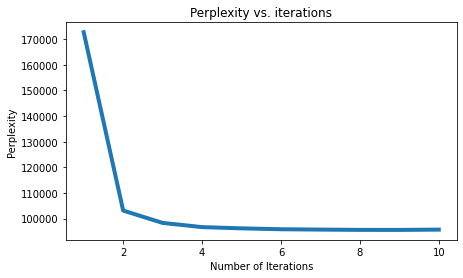

In [79]:
# Plot of perplexity for 10 iterations
plt.figure(figsize=(7,4))
plt.plot(range(1, len(perplexity) + 1), perplexity, linewidth=4)
plt.xlabel('Number of Iterations')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. iterations')
plt.rcParams.update({'font.size': 12})

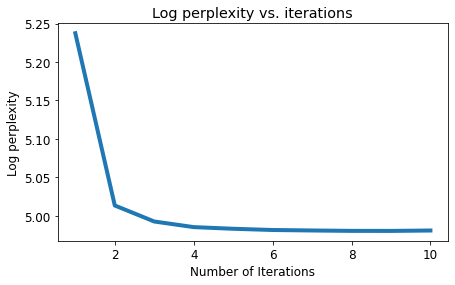

In [80]:
# Plot of log base 10 of perplexity
plt.figure(figsize=(7,4))
plt.plot(range(1, len(perplexity) + 1), np.log10(perplexity), linewidth=4)
plt.xlabel('Number of Iterations')
plt.ylabel('Log perplexity')
plt.title('Log perplexity vs. iterations')
plt.rcParams.update({'font.size': 12})

In [81]:
# Save cleaned fr_en 
#filename = 'cleaned_fr_en.joblib'
#joblib.dump(df, filename)

# Load the clean data 'clean_fr_en.joblib' from disk
#filename = 'cleaned_fr_en.joblib'
#data = joblib.load(filename)

In [82]:
fra = ['mais', 'sans', 'je']
ena = ['but', 'without', 'i']

align = {}
for f in fra:
  for e in ena:
    align[(e,f)] = round(t[(e,f)],4)

print("Alignment for some selected words:")
dict_to_dataframe(align) 

Alignment for some selected words:


,mais,sans,je
but,0.799,0.0000,0.0000
without,0.000,0.7354,0.0000
i,0.000,0.0000,0.5752


### Translation of french sentence

In [83]:
def translate(test,t,foreign_words=foreign_words,english_words=english_words):
  """
  INPUT :
        test --> foreign sentence to translate  
        t --> alignments 
        foreign_words --> French vocabulary from parallel corpus
        english_words --> English vocabulary from parallel corpus

  OUTPUT : translated english sentence 
  """
  e_best = []
  translate = {}
  for french in test.split():
    m = {}
    if french not in foreign_words:
        translate[('<OOV>',french)] = 0.0
        e_best.append('<OOV>')
        continue

    else:
      for eng in english_words:
        m[eng] = t[(eng,french)]
    
    inv_m = [(v,k) for k,v in m.items()]
    tup = sorted(inv_m)[0]
    e_best.append(tup[1])
    translate[(tup[1],french)] = round(tup[0],7)

  return translate , e_best

In [84]:
test_fr = test_data['French'].iloc[1]
test_en = test_data['English'].iloc[1]
print('French Sent :',test_fr)
print('English Sent :',test_en)

French Sent : ce serait la solution à adopter laquelle attirerait davantage l’attention des citoyens que la convention précédente
English Sent : it would be the way forward it would get far more public attention than the previous convention


In [85]:
trans1 = translate(test_fr,t)

In [86]:
print("Translation is given as below:")
print(test_fr.split()," --> ", trans1[1])

Translation is given as below:
['ce', 'serait', 'la', 'solution', 'à', 'adopter', 'laquelle', 'attirerait', 'davantage', 'l’attention', 'des', 'citoyens', 'que', 'la', 'convention', 'précédente']  -->  ['mr', 'mr', 'thirdly', 'and', 'even', 'it', 'i', '<OOV>', 'another', 'the', 'even', 'since', 'writing', 'thirdly', 'people', 'to']


In [87]:
test_fr = test_data['French'].iloc[2]
test_en = test_data['English'].iloc[2]
print('French Sent :',test_fr)
print('English Sent :',test_en)

French Sent : il y a aussi des questions verticales
English Sent : there are also some vertical issues


In [88]:
trans2 = translate(test_fr,t)

In [89]:
print("Translation is given as below:")
print(test_fr.split()," --> ", trans2[1])

Translation is given as below:
['il', 'y', 'a', 'aussi', 'des', 'questions', 'verticales']  -->  ['even', 'even', 'even', 'if', 'even', 'some', '<OOV>']


This translations are not even predicting the most common words correctly.

## Language Models

In [90]:
def N_gram(N,corpus_list):
  """
  INPUT:  N = n gram number
          corpus_list = list of sentences

  OUTPUT: returns a frequency dictionary of N grams.
  """

  N_gram = dict()

  for row in corpus_list:
    tokens = row.split()
    for i in range(len(tokens)-N+1): # N-grams
        try:
            N_gram[tuple(tokens[i:i+N])] += 1
        except:
            N_gram[tuple(tokens[i:i+N])] = 1

  return N_gram

In [91]:
trial = train_data['English']
print(trial[:5])

35637    it gave us all a chance to confront the sense ...
24313    that is certainly the main concern raised by t...
13144    mr president the president-in-office's speech ...
21060    thank you mrs berger may i congratulate you on...
44040    during the eu's budgetary review we must ensur...
Name: English, dtype: object


### Unigram

In [92]:
uni_gram = N_gram(1,trial)
uni_gram_dict = sorted(uni_gram.items(), key=lambda item : item[1], reverse=True)

In [93]:
len(uni_gram)

3842

In [94]:
#uni_gram
pd.DataFrame(uni_gram_dict,columns=('Uni Gram', 'Count')).head()

,Uni Gram,Count
0,"(the,)",1539
1,"(of,)",722
2,"(to,)",700
3,"(and,)",570
4,"(in,)",457


### Bigram

In [95]:
bi_gram = N_gram(2,trial)

In [96]:
print("Total length of all Bi-Grams:",len(bi_gram))

Total length of all Bi-Grams: 13171


In [97]:
bi_gram_dict = sorted(bi_gram.items(), key = lambda item: item[1], reverse=True)

In [98]:
type(bi_gram_dict)

list

In [99]:
pd.DataFrame(bi_gram_dict, columns=('Bi-Gram','Counts')).head()

,Bi-Gram,Counts
0,"(of, the)",221
1,"(in, the)",123
2,"(the, european)",87
3,"(to, the)",84
4,"(it, is)",76


In [100]:
def bigram_model(data, word,k_best = 5, V = len(english_words)):

  if type(word) != str or len(word.split()) != 1:
    return "Either type is not 'str' or word length not 1."

  unigram = N_gram(1,data)
  bigram = N_gram(2,data)

  next_word = {}

  for k, v in bigram.items():
    if k[0] != word:
      continue

    else:
      prob = (v + 1)/ (unigram[(word,)] + V)
      w2 = k[1]
      next_word[w2] = round(prob,5)

  next = sorted(next_word.items(), key=lambda item : item[1], reverse=True)
  df = pd.DataFrame(next, columns=('Next Word', 'Probability'))

  if len(next) <= k_best:
    return df
  else:
    return df.head(k_best)

In [101]:
# Predict next word using Bi-Gram model
word = 'all'
print("Prediction of next word given the word '{}' using Bi-Gram Model:".format(word))
bigram_model(trial,word)

Prediction of next word given the word 'all' using Bi-Gram Model:


,Next Word,Probability
0,the,0.00308
1,know,0.00103
2,initiatives,0.00077
3,that,0.00077
4,i,0.00077


In [102]:
# Predict next word using Bi-Gram model
word = 'but'
print("Prediction of next word given '{}' using Bi-Gram Model:".format(word))
bigram_model(trial,word)

Prediction of next word given 'but' using Bi-Gram Model:


,Next Word,Probability
0,also,0.00256
1,it,0.00205
2,we,0.00179
3,i,0.00153
4,the,0.00153


### Trigram

In [103]:
tri_gram = N_gram(3,trial)

In [104]:
len(tri_gram)

17188

In [105]:
tri_gram_list = sorted(tri_gram.items(), key = lambda item: item[1], reverse=True)

In [106]:
pd.DataFrame(tri_gram_list, columns=('Tri-Gram','Counts')).head()

,Tri-Gram,Counts
0,"(the, european, union)",32
1,"(of, the, european)",25
2,"(in, order, to)",18
3,"(the, committee, on)",15
4,"(the, member, states)",15


In [107]:
def trigram_model(data, word_list, k_best = 5, V = len(english_words)):

  if type(word_list) != list or len(word_list) != 2:
    return "Either words type is not a 'list' or number of words not equal to 2."


  bigram = N_gram(2,data)
  trigram = N_gram(3,data)

  next_word = {}

  for k, v in trigram.items():
    if (k[0],k[1]) != tuple(word_list):
      continue

    else:
      prob = (v + 1)/ (bigram[tuple(word_list)] + V)
      w3 = k[2]
      next_word[w3] = round(prob,5)

  next = sorted(next_word.items(), key=lambda item : item[1], reverse=True)
  df = pd.DataFrame(next, columns=('Next Word', 'Probability'))

  if len(next) <= k_best:
    return df
  else:
    return df.head(k_best)

In [108]:
# Predict next likely word
#trigram_model(['when','in'],1)
words = ['in','the']
print("Prediction of next word given '{}' using Tri-Gram Model:".format(words))
trigram_model(trial,words)

Prediction of next word given '['in', 'the']' using Tri-Gram Model:


,Next Word,Probability
0,european,0.00227
1,council,0.00151
2,future,0.00126
3,world,0.00126
4,case,0.00101


### Evaluation - Perplexity Score

In [109]:
def perp(data,ngram = 2, V = len(english_words)):
  N = ngram
  n_gram = N_gram(N, data)
  n_1_gram = N_gram(N-1, data)

  PP = []
  prob = []

  for row in data:
    tokens = row.split()
    for i in range(len(tokens)-N+1): # N-grams
      key = tuple(tokens[i:i+N])
      
      # Count if n gram
      if key in n_gram.keys():
        c = n_gram[key]
      else:
        c = 0

      # Count of n-1 gram
      if key[0] in n_1_gram.keys():
        C = n_1_gram[key[0]]
      else:
        C = 0

      # p(Wn|Wn-1)
      prob.append(-1.0*log((c + 1)/(C + V)))

    # Entropy
    H = sum(prob)/len(tokens)

    # Perplexity --> PP = 2^H
    PP.append(pow(2,Decimal(H)))
  return PP

In [110]:
# Evaluation of Bi-Gram Model
bigram_perp = perp(trial,2)

In [111]:
len(bigram_perp)

800

/usr/local/lib/python3.7/dist-packages/matplotlib/ticker.py:2161: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


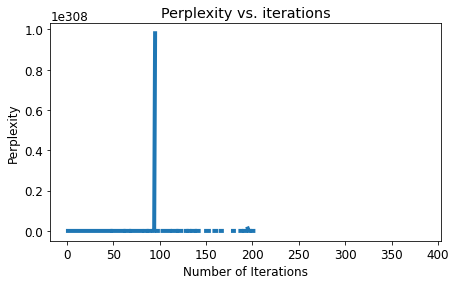

In [112]:
# Plot of perplexity for 10 iterations
plt.figure(figsize=(7,4))
plt.plot(range(1, len(bigram_perp) + 1), bigram_perp, linewidth=4)
plt.xlabel('Number of Iterations')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. iterations')
plt.rcParams.update({'font.size': 12})

/usr/local/lib/python3.7/dist-packages/matplotlib/ticker.py:2161: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


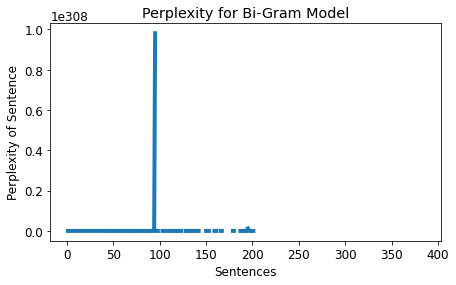

In [113]:
# Bi-Gram model Perplexity for all sentences
plt.figure(figsize=(7,4))
plt.plot(range(1, len(bigram_perp) + 1), bigram_perp, linewidth=4)
plt.xlabel('Sentences')
plt.ylabel('Perplexity of Sentence')
plt.title('Perplexity for Bi-Gram Model')
plt.rcParams.update({'font.size': 12})

This models do not give translations as one might expect from it. To improve this translation model
- It needs to be trained on entire corpus (now it was trained on `0.000516%` of data)
- To capture the context associated with words: Phrase-based models need to be implemented.

**Thank You!**